In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report


In [2]:
price_data = pd.read_csv('../data/price_1.csv')

In [3]:

# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [4]:

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)


Correct Prediction (%):  69.9122106943336


In [5]:

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df


,precision,recall,f1-score,support
Down Day,0.680251,0.714992,0.697189,607.000000
Up Day,0.718699,0.684211,0.701031,646.000000
accuracy,0.699122,0.699122,0.699122,0.699122
macro avg,0.699475,0.699601,0.699110,1253.000000
weighted avg,0.700073,0.699122,0.699170,1253.000000


Accuracy: 0.699122106943336
Percision: 0.71869918699187
Recall: 0.6842105263157895
Specificity: 0.71499176276771


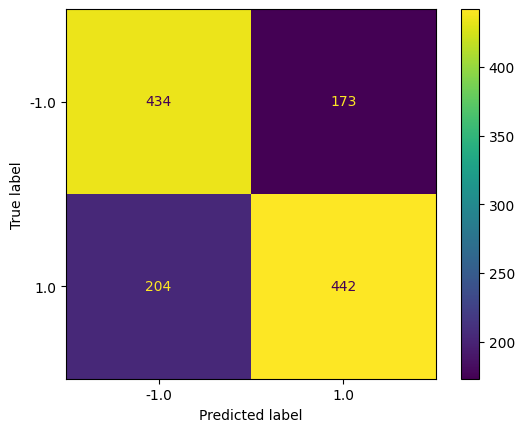

In [6]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()


In [7]:


feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp


r_percent               0.197601
k_percent               0.194881
RSI                     0.181161
MACD                    0.155918
Price_Rate_Of_Change    0.149358
On Balance Volume       0.121081
dtype: float64

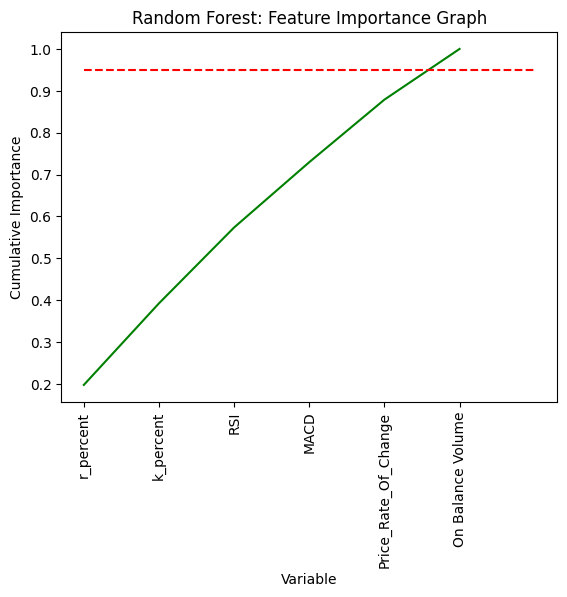

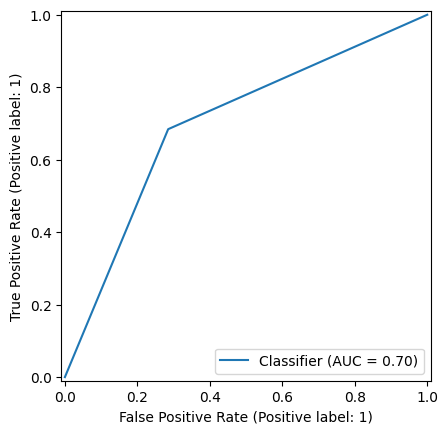

In [8]:

# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')
rfc_disp = RocCurveDisplay.from_predictions( y_test,y_pred)
plt.show()


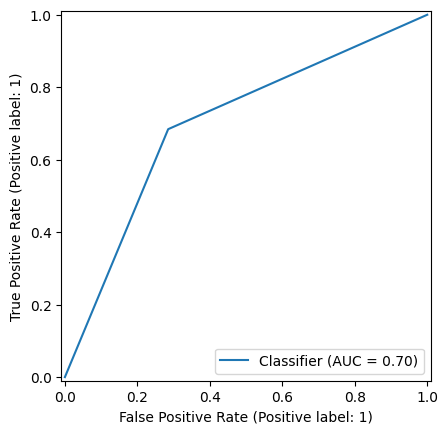

In [9]:
# y_pred = clf.decision_function(X_test)
rfc_disp = RocCurveDisplay.from_predictions(y_test,y_pred)
plt.show()



In [10]:

print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))


Random Forest Out-Of-Bag Error Score: 0.7048176736758052


In [11]:

# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [12]:

# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)



'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=16, min_samples_split=40, n_estimators=1600; total time=   7.9s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=  13.9s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=  13.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/

Correct Prediction (%):  72.70550678371907


,precision,recall,f1-score,support
Down Day,0.680251,0.714992,0.697189,607.000000
Up Day,0.718699,0.684211,0.701031,646.000000
accuracy,0.699122,0.699122,0.699122,0.699122
macro avg,0.699475,0.699601,0.699110,1253.000000
weighted avg,0.700073,0.699122,0.699170,1253.000000


r_percent               0.197601
k_percent               0.194881
RSI                     0.181161
MACD                    0.155918
Price_Rate_Of_Change    0.149358
On Balance Volume       0.121081
dtype: float64

Correct Prediction (%):  72.70550678371907


,precision,recall,f1-score,support
Down Day,0.680251,0.714992,0.697189,607.000000
Up Day,0.718699,0.684211,0.701031,646.000000
accuracy,0.699122,0.699122,0.699122,0.699122
macro avg,0.699475,0.699601,0.699110,1253.000000
weighted avg,0.700073,0.699122,0.699170,1253.000000


r_percent               0.197601
k_percent               0.194881
RSI                     0.181161
MACD                    0.155918
Price_Rate_Of_Change    0.149358
On Balance Volume       0.121081
dtype: float64

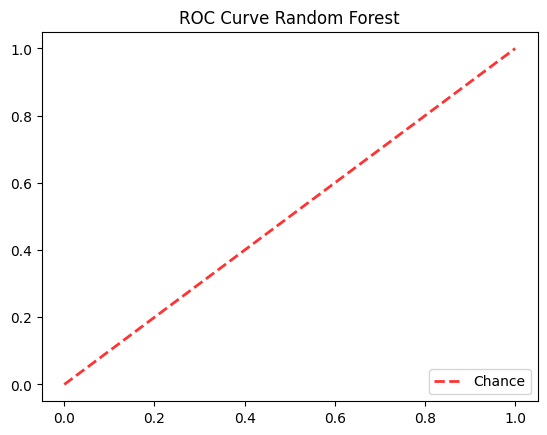

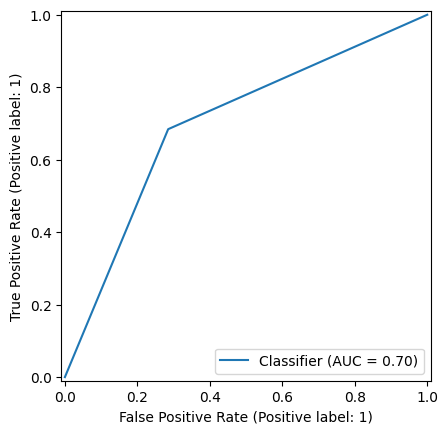

In [15]:

'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = RocCurveDisplay.from_predictions( y_test, y_pred)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

In [14]:
import joblib

# # Save the model
joblib.dump(rand_frst_clf, '../dump/random_forest_model.pkl')


['../dump/random_forest_model.pkl']